In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from gplearn.genetic import SymbolicTransformer, SymbolicClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV

df = pd.read_csv("kaggle/working/FeatureFrame.csv", index_col=0)

X = df.iloc[:, :-1]
y = df.iloc[:, -1]

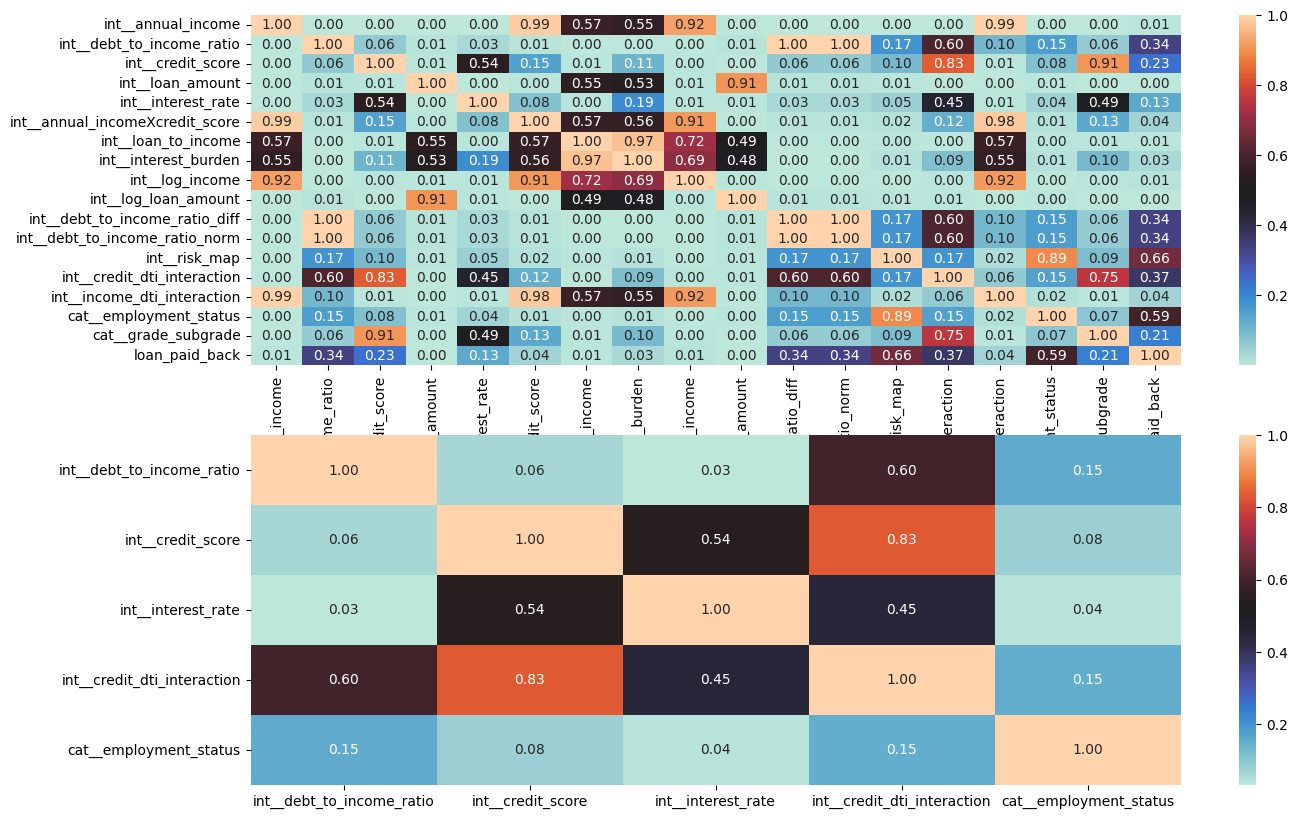

In [25]:
corr = df.corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop = [c for c in upper.columns if any(upper[c] > 0.9)]
X_reduced = X.drop(columns=to_drop)
corr_target = X_reduced.corrwith(y).abs()
selected = corr_target[(corr_target > 0.05) & (corr_target < 0.6)].index
X_gp = X_reduced[selected]
corr2 = X_gp.corr().abs()

fig, ax = plt.subplots(2, 1, figsize=(15, 10))
sns.heatmap(corr, cmap="icefire", annot=True, fmt="0.2f", ax=ax[0])
sns.heatmap(corr2, cmap="icefire", annot=True, fmt="0.2f", ax=ax[1])
plt.show()

In [ ]:
gpt = SymbolicTransformer(
    generations=20,  # number of evolution cycles
    population_size=2000,  # number of candidate formulas
    hall_of_fame=100,  # keep best 50 formulas
    n_components=10,  # how many new features to produce
    function_set=("add", "sub", "mul", "div", "sqrt", "log", "abs", "sin", "cos"),
    feature_names=X_gp.columns,
    parsimony_coefficient=0.00001,  # penalty for overly complex formulas
    max_samples=0.9,
    # random_state=42,
    verbose=1,
    n_jobs=-1,
)

gpt.fit(X_gp, y)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    10.35         0.276761       10         0.688991         0.687184     30.68m
   1     9.23         0.488472       15         0.696438         0.697014     26.69m
   2    10.48         0.519323       11         0.697063         0.695649     25.00m
   3    13.29         0.529287       12         0.706429         0.707921     25.82m
   4    16.26         0.536977       59          0.70847         0.701906     27.88m
   5    19.01         0.541693       16         0.713128          0.70939     28.12m
   6    20.39         0.558178       18         0.714334         0.709899     26.88m
   7    21.70         0.572622       18         0.714378         0.709411     25.44m
   8    22.80         0.565149       38         0.716164          0.71538  

SymbolicTransformer(feature_names=Index(['int__debt_to_income_ratio', 'int__credit_score', 'int__interest_rate',
       'int__credit_dti_interaction', 'cat__employment_status'],
      dtype='object'),
                    function_set=('add', 'sub', 'mul', 'div', 'sqrt', 'log',
                                  'abs', 'sin', 'cos'),
                    max_samples=0.9, n_jobs=-1, parsimony_coefficient=1e-05,
                    population_size=2000, verbose=1)

In [28]:
X_train_new = gpt.transform(X_gp)
for i, program in enumerate(gpt._best_programs):
    print(f"GP_{i}: {program}")


GP_0: sin(mul(abs(sin(mul(sin(abs(mul(sin(sub(int__credit_dti_interaction, mul(cos(sub(sqrt(mul(cos(log(cat__employment_status)), add(0.674, int__credit_dti_interaction))), cat__employment_status)), -0.524))), add(0.674, int__credit_dti_interaction)))), add(0.674, abs(sin(sub(int__credit_dti_interaction, mul(mul(sin(abs(mul(abs(abs(sub(div(add(sqrt(sin(sub(int__credit_dti_interaction, mul(mul(sin(abs(mul(abs(abs(sub(div(add(sqrt(sqrt(cos(log(add(0.674, int__credit_dti_interaction))))), sub(int__credit_dti_interaction, mul(cos(sub(sqrt(cos(sub(sqrt(mul(sub(abs(abs(sqrt(cos(int__debt_to_income_ratio)))), cat__employment_status), add(0.674, int__credit_dti_interaction))), cat__employment_status))), cat__employment_status)), -0.524))), cat__employment_status), int__debt_to_income_ratio))), add(0.674, int__credit_dti_interaction)))), add(sub(int__credit_dti_interaction, mul(cos(sub(cos(sub(int__credit_dti_interaction, abs(add(0.674, int__credit_dti_interaction)))), cat__employment_status)),

In [33]:
cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

gpc = SymbolicClassifier(
    generations=20,  # number of evolution cycles
    population_size=2000,  # number of candidate formulas
    function_set=("add", "sub", "mul", "div", "sqrt", "log", "abs", "sin", "cos"),
    feature_names=X_gp.columns,
    parsimony_coefficient=0.00001,  # penalty for overly complex formulas
    max_samples=0.9,
    random_state=42,
    verbose=1,
    n_jobs=-1,
)

score_gpc = cross_val_score(gpc, X_gp, y, cv=cv, scoring="roc_auc")
print(
    f"xgb scores across folds: {score_gpc} - Mean Score: {score_gpc.mean():0.4f}"
)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    10.55         0.837921       33         0.348489         0.348935     29.48m
   1    12.03         0.640164       33         0.324406         0.322731     26.68m
   2    19.20         0.630174       46         0.312382         0.312427     30.31m
   3    25.80         0.675975       18         0.296847         0.296586     32.26m
   4    31.80         0.656714       18         0.296395         0.300659     34.51m
   5    34.76         0.623696       23         0.292761         0.297536     35.21m
   6    34.61         0.574845       21         0.293686         0.294815     34.82m
   7    33.27         0.561258       61         0.286926         0.286324     32.69m
   8    30.42         0.527757       74         0.284131         0.285515  

KeyboardInterrupt: 

In [ ]:
import joblib
joblib.dump(gpt, "kaggle/working/best/" + "gpt.joblib")


In [ ]:
X_train_new.to_csv("kaggle/working/best/" + "gpt.csv")